<a href="https://colab.research.google.com/github/Kasra2020/YOLOv10-DIOR-CLEWS-course/blob/main/CLEWS_DL_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This repository serves only as the supportive material for the lecture entitled "Deep Learning Architectures - Theory and Applications in Earth Observation", given at Univeristy of Potsdam on July 7th, 2025. The lecture is part of a lecture series within the "Climate, Earth, Water, Sustainability (CLEWS)" course organized by Johan Rockström et. al.

- The YOLO model is implemented based on the paper "Wang, Ao, et al. "Yolov10: Real-time end-to-end object detection." Advances in Neural Information Processing Systems 37 (2024): 107984-108011".

- The dataset utilized in this course is a subset of DIOR, sourced from "Li, Ke, et al. "Object detection in optical remote sensing images: A survey and a new benchmark." ISPRS journal of photogrammetry and remote sensing 159 (2020): 296-307".

Please note that the purpose of this notebook is purely educational. Due to time and computational constraints, we only use a subset of DIOR data: 139 images containing 1,232 instances. Therefore, our goal is not to develop or train the most accurate model. The model's low accuracy is due to the limited amount of data used to train the YOLOv10 model from scratch. Consequently, the results are suboptimal. However, performance improves slightly when fine-tuning a pretrained model with similar data.

# Exploratory analysis of the original data

Number of images per object class:

airplane                      : 1387

airport                       : 1310

baseballfield                 : 2439

basketballcourt               : 1369

bridge                        : 2175

chimney                       : 854

dam                           : 986

expressway-service-area       : 1125

expressway-toll-station       : 1218

golffield                     : 946

groundtrackfield              : 2312

harbor                        : 1470

overpass                      : 2018

ship                          : 2697

stadium                       : 1200

storagetank                   : 1667

tenniscourt                   : 2581

trainstation                  : 994

vehicle                       : 6415

windmill                      : 1616

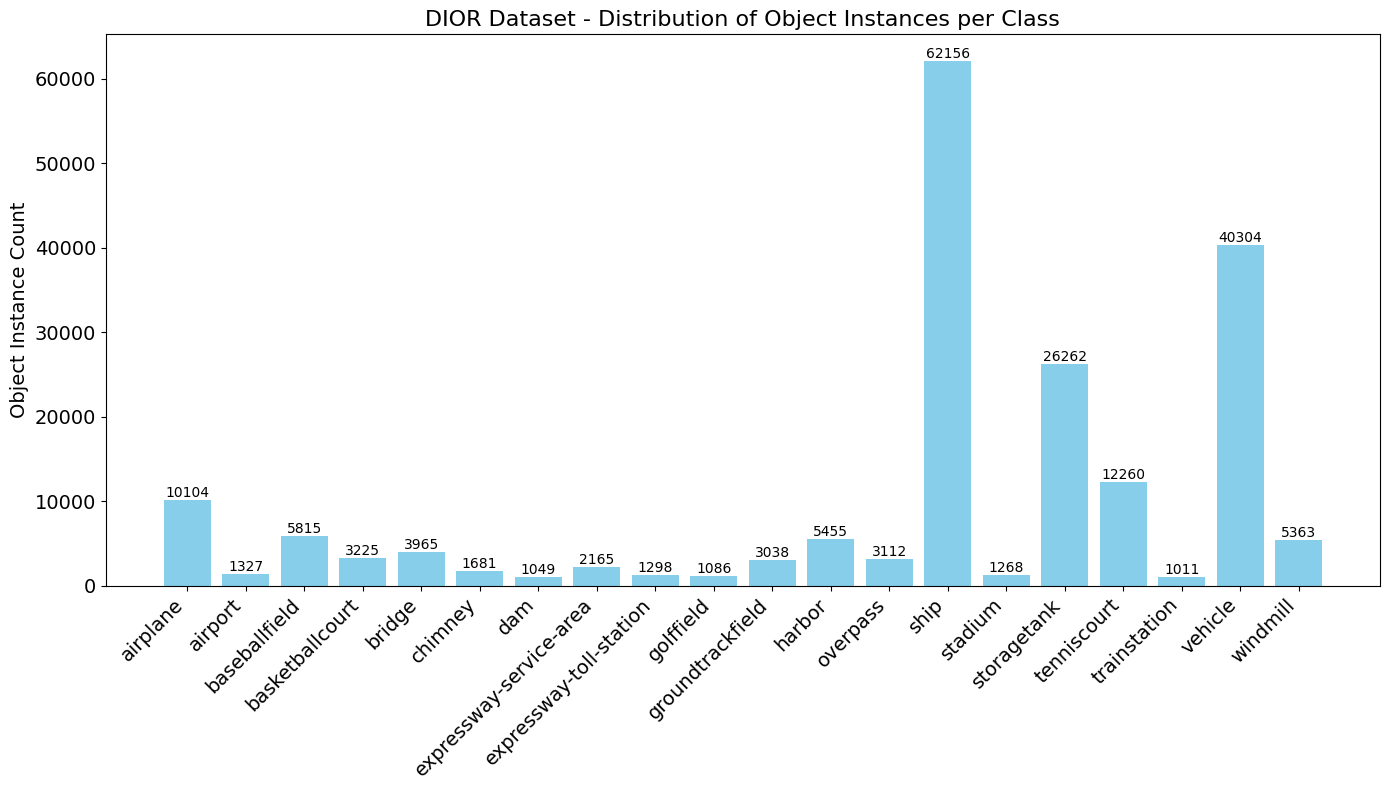

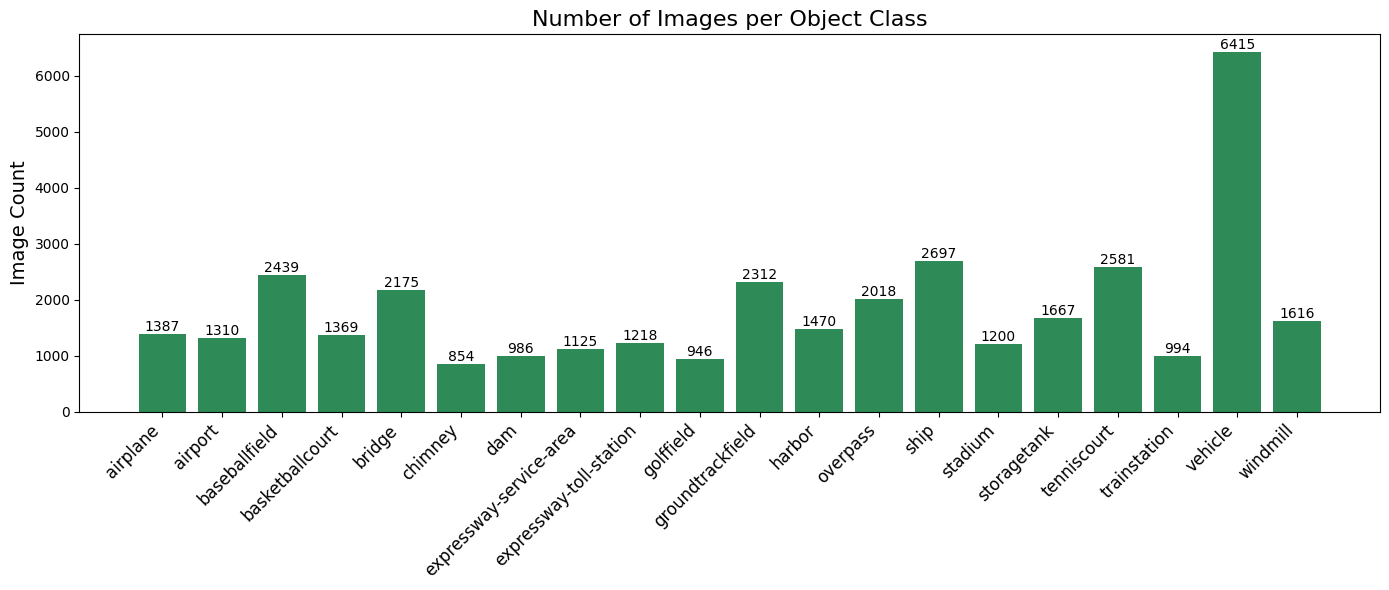

In [1]:
# ==============================================================================
#  Loading the necessary dependencies
# ==============================================================================

!pip install ultralytics
import os
import cv2
import yaml
import torch
import random
import ultralytics
from ultralytics import YOLO
from google.colab import drive
import matplotlib.pyplot as plt
from collections import defaultdict


# ==============================================================================
#  Mounting the Google drive and changin the directory
# ==============================================================================

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [11]:
# ==============================================================================
#  Checking if the Ultralytics library is properly loaded, and GPU is available
# ==============================================================================

print("Ultralytics version:", ultralytics.__version__)
print(torch.cuda.is_available())

Ultralytics version: 8.3.162
True


In [56]:
labels_dir = "./YOLO_data/labels/train"
yaml_path = "./dior.yaml"


with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
    class_names = data_yaml.get('names', {})


class_counts = defaultdict(int)

for filename in os.listdir(labels_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(labels_dir, filename)
        with open(file_path, "r") as f:
            for line in f:
                if line.strip():
                    class_id = int(line.strip().split()[0])
                    class_counts[class_id] += 1

print("Instance count per class:")
for class_id, count in sorted(class_counts.items()):
    class_name = class_names.get(class_id, f"Class {class_id}")
    print(f"{class_name}: {count} instances")

Instance count per class:
airplane: 74 instances
airport: 12 instances
baseballfield: 28 instances
basketballcourt: 41 instances
bridge: 26 instances
chimney: 7 instances
dam: 10 instances
Expressway-Service-area: 19 instances
Expressway-toll-station: 13 instances
golffield: 11 instances
groundtrackfield: 13 instances
harbor: 54 instances
overpass: 19 instances
ship: 361 instances
stadium: 13 instances
storagetank: 170 instances
tenniscourt: 54 instances
trainstation: 8 instances
vehicle: 274 instances
windmill: 35 instances


In [54]:
# ==============================================================================
#                         Loading Yolov10 architecture
# ==============================================================================

model = YOLO("yolov10m.yaml")
# model = YOLO("yolov10m.pt")
results_training = model.train(data="./dior.yaml", epochs=50, imgsz=800)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./dior.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10m.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profil

train: Scanning /content/drive/MyDrive/YOLO_data/labels/train.cache... 139 images, 0 backgrounds, 0 corrupt: 100%|██████████| 139/139 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.8±0.6 ms, read: 128.4±51.2 MB/s, size: 504.6 KB)


val: Scanning /content/drive/MyDrive/YOLO_data/labels/val.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      13.8G       7.41      16.78      9.139        251        800: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      13.3G      7.642      16.93      9.047         35        800: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      13.4G      7.276      15.24       8.99        286        800: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      13.2G      7.541      15.91      8.657         95        800: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      13.2G      7.497      15.44      8.557        143        800: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50        13G      7.335      14.67      8.425        222        800: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      13.1G       7.34      15.55      8.266         96        800: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      13.2G      7.086      15.13      8.312         53        800: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      13.2G      7.254      13.37       8.14        124        800: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      13.3G      7.396      13.62      7.972        228        800: 100%|██████████| 9/9 [00:09<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      13.2G       6.92      13.14       7.93        118        800: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      13.6G      6.802      13.12      7.772        291        800: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      13.2G      6.799      12.39      7.613        104        800: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      13.2G      6.795      12.72      7.573        216        800: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      13.5G      6.502      11.65      7.271         66        800: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      13.2G      6.982      11.61      7.288        259        800: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      13.4G      6.405      10.84      6.847        182        800: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         29        283          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      13.1G      6.561      12.41      7.218         49        800: 100%|██████████| 9/9 [00:09<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         29        283     0.0134    0.00355    0.00738    0.00146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      13.5G      6.608      11.09      6.832         55        800: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         29        283    0.00447    0.00566    0.00324   0.000723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      13.2G      6.438      10.69      6.854        233        800: 100%|██████████| 9/9 [00:09<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         29        283      0.393     0.0101     0.0135    0.00562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      13.5G      6.454      10.94       6.87        236        800: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         29        283      0.396     0.0123     0.0146     0.0059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      13.1G      6.455      10.58       6.67        185        800: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         29        283      0.332     0.0237     0.0121    0.00417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      13.3G      6.051      10.58      6.586        135        800: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         29        283      0.332     0.0277     0.0114     0.0034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      13.5G      6.251      9.867      6.454         46        800: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         29        283      0.495     0.0144     0.0139    0.00347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      13.1G      6.022      9.536      6.348         88        800: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         29        283      0.296     0.0201     0.0158     0.0039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      13.1G      5.944      9.538      6.198         72        800: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         29        283      0.248     0.0204     0.0205    0.00674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      13.4G      5.931      9.913      6.304        142        800: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         29        283      0.296     0.0233     0.0267     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      13.7G      5.906       9.54      6.146        113        800: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         29        283      0.505     0.0137      0.018    0.00868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      13.6G      6.172      10.17      6.454         79        800: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         29        283      0.447     0.0101     0.0148    0.00643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      13.5G      5.826      9.377      6.059        236        800: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         29        283      0.395     0.0115     0.0145    0.00636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      13.1G      5.806      9.832      6.323        280        800: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         29        283      0.448     0.0151      0.017    0.00896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      13.6G      5.738      9.698      6.156         59        800: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         29        283      0.511     0.0144     0.0222     0.0116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      13.2G      5.517        8.9      5.807        121        800: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         29        283      0.347     0.0209     0.0248     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      13.5G      5.951      9.457      6.251        116        800: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         29        283      0.343     0.0225      0.024     0.0113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      12.9G      5.653      9.175      6.042        156        800: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         29        283      0.343     0.0251      0.025     0.0107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      13.1G      5.736      8.556      5.779        125        800: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         29        283      0.427     0.0397     0.0301     0.0137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50        13G      5.824      8.764      5.927        141        800: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         29        283       0.43      0.044     0.0311     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      13.2G      5.523      8.855      5.937        105        800: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         29        283      0.251     0.0437     0.0287     0.0139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      13.3G       5.63      8.758      5.913        149        800: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         29        283      0.407     0.0392     0.0272     0.0134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      13.1G      5.783       8.31      5.625        122        800: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         29        283      0.467     0.0351     0.0298     0.0147


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      13.4G      5.403      9.685      5.732         82        800: 100%|██████████| 9/9 [00:09<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         29        283      0.525     0.0464     0.0295     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      13.1G      5.209      9.826      5.848        100        800: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         29        283      0.524     0.0463      0.031     0.0155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      13.1G      5.333      9.538      5.746         56        800: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         29        283      0.515     0.0483     0.0344     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      13.3G      5.175      8.959      5.647         89        800: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         29        283      0.511     0.0304     0.0329     0.0159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      13.5G      5.294      9.575      5.668         33        800: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         29        283      0.511     0.0257     0.0329     0.0155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      13.2G      5.254      8.998      5.547         37        800: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         29        283      0.405     0.0283     0.0319      0.015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      13.2G      5.214      8.969      5.489         58        800: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         29        283      0.351     0.0299     0.0329     0.0161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      13.4G      5.152      9.608      5.701        129        800: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         29        283      0.298     0.0345     0.0347     0.0162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      13.1G      5.295      9.219      5.703         66        800: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         29        283      0.299     0.0365     0.0339     0.0161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      12.9G      5.223      9.341      5.731        246        800: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         29        283      0.297     0.0378     0.0347     0.0167



50 epochs completed in 0.171 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 33.5MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 33.5MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 136 layers, 15,324,748 parameters, 0 gradients, 58.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


                   all         29        283      0.298     0.0378     0.0347     0.0165
              airplane          4         23          0          0     0.0084    0.00385
               airport          1          1          0          0          0          0
         baseballfield          5         14          1          0      0.129     0.0726
       basketballcourt          2          5          0          0          0          0
                bridge          5          9          0          0          0          0
               chimney          2          4          0          0          0          0
                   dam          1          1          0          0          0          0
Expressway-Service-area          3          6          1          0          0          0
Expressway-toll-station          2          2          1          0          0          0
             golffield          1          1          0          0          0          0
      groundtrackfi


image 1/1 /content/drive/MyDrive/YOLO_data/images/test/16816.jpg: 800x800 1 trainstation, 49.3ms
Speed: 2.8ms preprocess, 49.3ms inference, 0.6ms postprocess per image at shape (1, 3, 800, 800)


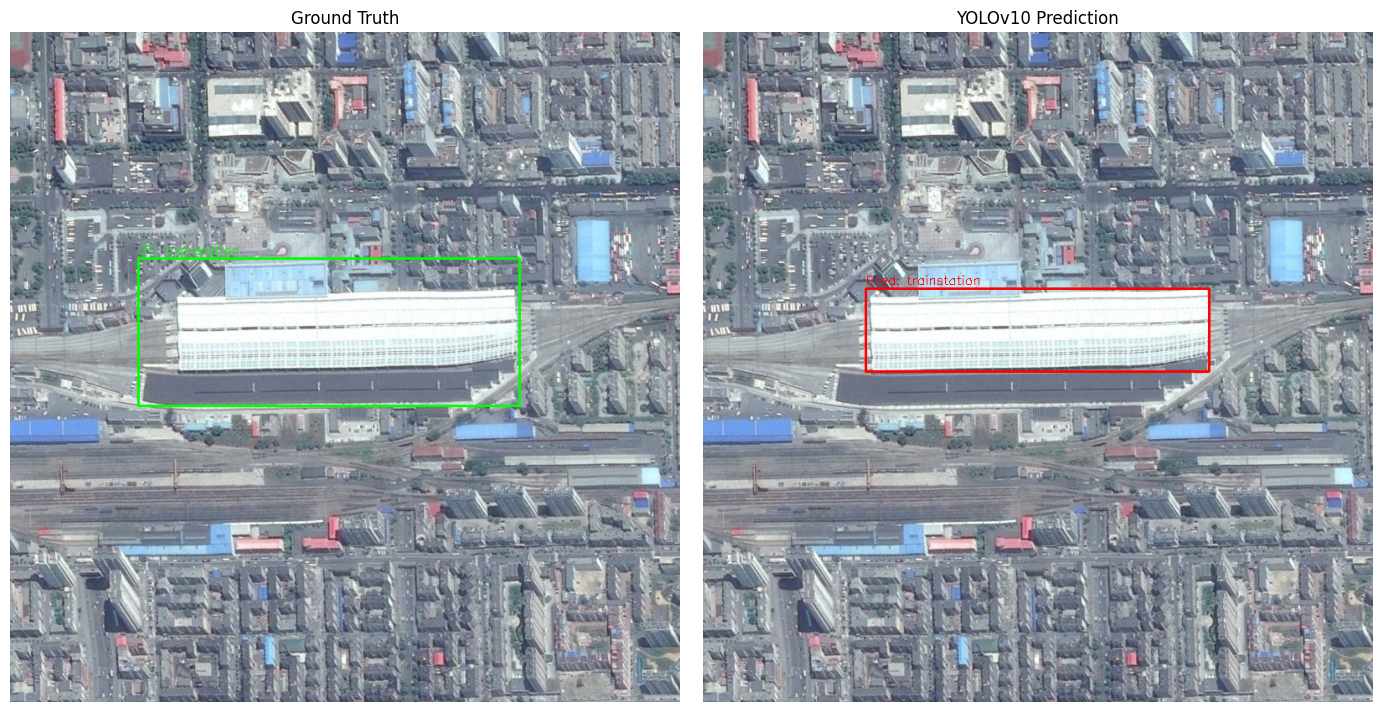

In [55]:
# ==============================================================================
#                         Loading the yaml classes from yaml file
# ==============================================================================

def load_classes_from_yaml(yaml_path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    names = data.get('names')
    if isinstance(names, dict):
        return [names[k] for k in sorted(names)]
    elif isinstance(names, list):
        return names
    else:
        raise ValueError("Unsupported 'name' format in .yaml file.")




# ==============================================================================
#        Select a test sample at random to qualitatively assess the results
# ==============================================================================

test_pth = "./YOLO_data/images/test"
image_files = [f for f in os.listdir(test_pth) if f.endswith(('.jpg'))]
random_image = random.choice(image_files)
image_id = os.path.splitext(random_image)[0]
image_path = f"./YOLO_data/images/test/{image_id}.jpg"
gt_label_path = f"./YOLO_data/labels/test/{image_id}.txt"
model_path = "./runs/detect/train/weights/best.pt"


CLASSES = load_classes_from_yaml('./dior.yaml')

def read_yolo_labels(path):
    boxes = []
    if not os.path.exists(path):
        return boxes
    with open(path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls_id = int(parts[0])
            x_center, y_center, w, h = map(float, parts[1:5])
            boxes.append((cls_id, x_center, y_center, w, h))
    return boxes

def draw_boxes(img, boxes, color=(0, 255, 0), label_prefix=''):
    h, w, _ = img.shape
    for cls_id, xc, yc, bw, bh in boxes:
        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)
        label = f"{label_prefix}{CLASSES[cls_id]}"
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, label, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img


model = YOLO(model_path)


results = model.predict(source=image_path, save=False, conf=0.25)


pred_boxes = []
img_pred = cv2.imread(image_path)
img_gt = img_pred.copy()

for r in results:
    for box in r.boxes:
        cls_id = int(box.cls)
        xc, yc, w, h = map(float, box.xywhn[0])
        pred_boxes.append((cls_id, xc, yc, w, h))

gt_boxes = read_yolo_labels(gt_label_path)
img_gt = draw_boxes(img_gt, gt_boxes, color=(0, 255, 0), label_prefix='GT: ')
img_pred = draw_boxes(img_pred, pred_boxes, color=(0, 0, 255),
                      label_prefix='Pred: ')


img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(img_gt)
axs[0].set_title("Ground Truth")
axs[0].axis('off')

axs[1].imshow(img_pred)
axs[1].set_title("YOLOv10 Prediction")
axs[1].axis('off')

plt.tight_layout()
plt.show()